# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [ ]:
!pip install scikit-learn==1.1.3

## Подготовка данных

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_validate
import warnings

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('/datasets/autos.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [ ]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Приводим наименования столбцов к строчным буквам

In [ ]:
columns_new = []
for col in data.columns:
    columns_new.append(re.sub('(?<!^)(?=[A-Z])', '_', col ).lower())
data.columns = columns_new

In [ ]:
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

Оцениваем пропущенные значения

In [ ]:
data.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

In [ ]:
data_columns = ['vehicle_type','gearbox','model','fuel_type','repaired']

for col in data_columns:
    print('В столбце {} нулевых значений {:.1%}'. format(col, data[col].isna().value_counts()[1] / len(data)))

В столбце vehicle_type нулевых значений 10.6%
В столбце gearbox нулевых значений 5.6%
В столбце model нулевых значений 5.6%
В столбце fuel_type нулевых значений 9.3%
В столбце repaired нулевых значений 20.1%


In [ ]:
data_copy = data.copy()

Найдем и удалим дубликаты

In [ ]:
data.duplicated().sum()

4

In [ ]:
data = data.drop_duplicates().reset_index(drop=True)

Исследуем значения в столбцах на предмет артефактов.

In [1]:
for col in data.columns:
    print(data[col].unique())

Заполним данные по vehicle_type - тип кузова, fuel_type - тип топлива, gearbox - тип коробки передач наиболее встречающимися по группе моделей автомобиля

In [ ]:
def zero_fill (col):
    data[col].value_counts()[0]
    data[col].replace(np.nan,inplace = True)
zero_fill('model')

In [ ]:
data['vehicle_type'] = data['vehicle_type'].fillna(data.groupby('model')['vehicle_type']
                                                       .transform(lambda x: x.value_counts().idxmax()))
data['gearbox'] = data['gearbox'].fillna(data.groupby('model')['gearbox']
                                             .transform(lambda x: x.value_counts().idxmax()))
data['fuel_type'] = data['fuel_type'].fillna(data.groupby('model')['fuel_type']
                                                 .transform(lambda x: x.value_counts().idxmax()))

Обработаем целевую переменную.

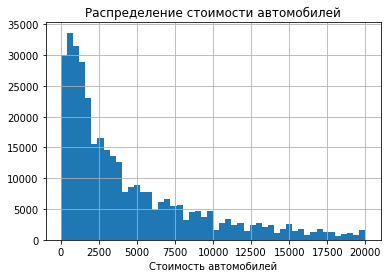

In [ ]:
#4.price
data['price'].hist(bins=50, grid = True)
plt.title("Распределение стоимости автомобилей")
plt.xlabel('Стоимость автомобилей', fontsize=10)
plt.show()

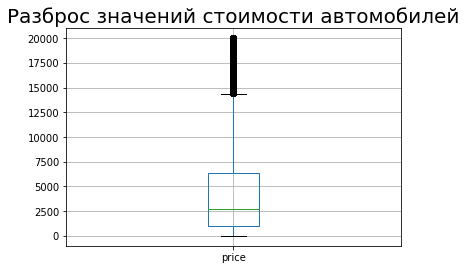

In [ ]:
data.boxplot(column='price')
plt.title('Разброс значений стоимоcти автомобилей',fontsize=20, loc= 'center')
plt.show()

In [ ]:
data['price'].quantile([0.05,0.95])

0.05      200.0
0.95    14600.0
Name: price, dtype: float64

Отбросим выбросы целевой переменной и сформируем данные с учетом стоимости автомобиля от 250 евро до 14800 евро

In [ ]:
data = data[(data['price']>200) & (data['price']<=14600)]

Мощность автомобиля отфильтруем в интервале от 16 до 1600 л.с.

Изучила перечень транспортных средств с минимальной мощностью, нашла самый минимальный мопед Мопед Рига 7 - 2 л.с., а самым мощным легковым автомобилем в мире назван Dagger GT компании TranStar Racing LLC с мощностью двигателя в 2028 л. с.). Но мы видим, что очень много значений около нуля. Что это? выбросы или велосипеды??


<AxesSubplot:>

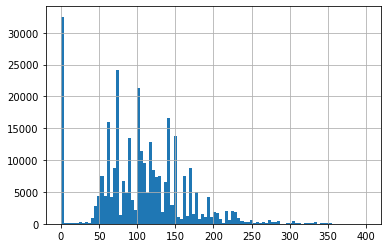

In [ ]:
data[data['power']<400]['power'].hist(bins=100, grid = True)

In [ ]:
data = data[(data['power']>38) & (data['power']<2028)]

В данных о дате регистрации автомобиля много встречается записей несоответствующих году. Максимальный год регистрации автомобиля выберем по дате скачивания анкеты - 2016, минимальный - начало 20 века

In [ ]:
data['date_crawled'].max()

'2016-04-07 14:36:58'

In [ ]:
data = data[(data['registration_year']>=1900) & (data['registration_year']<=2016)]

Учитывая, что машины как правило чаще ремонтируются чем не ремонтируются, пропуски данных заполним "yes".

In [ ]:
data['repaired'] = data['repaired'].fillna('yes')

In [ ]:
#превратила "repaired" в категориальный бинарный признак
data.loc[data['repaired'] == 'yes','repaired'] = '1'
data.loc[data['repaired'] == 'no','repaired'] = '0'
data = data.astype({'repaired':'int64'})

In [ ]:
data.duplicated().sum()

0

In [ ]:
data.shape

(273627, 16)

In [ ]:
data.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

Удаляемые признаки не влияют из логики рассуждения: даты скачикания анкет и даты из размещения на сайте, дата последней активности не характеризуют сам автомобиль, поэтому и на цену никак повлиять не могут. Но попробую показать.


Исключим данные не влияющие на цену авто

DateCrawled — дата скачивания анкеты из базы      
DateCreated — дата создания анкеты   
NumberOfPictures — количество фотографий автомобиля   
PostalCode — почтовый индекс владельца анкеты (пользователя)  
LastSeen — дата последней активности пользователя  
RegistrationMonth — месяц регистрации автомобиля  

In [ ]:
def plot_cat (col, price):
    data.plot(x=col,y=price, kind='scatter')
    plt.title(f'Зависимость цены машины от {col}')
    plt.xlabel(f'{col}, ед.', fontsize=10)
    plt.show()

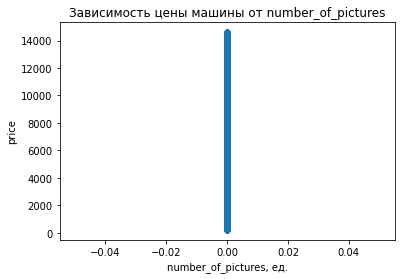

In [ ]:
plot_cat('number_of_pictures', 'price')

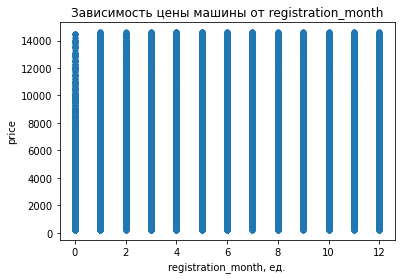

In [ ]:
plot_cat('registration_month', 'price')

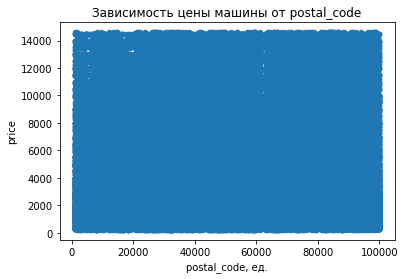

In [ ]:
plot_cat('postal_code', 'price')

На графиках видно, что выбраные признаки, не связанные напрямую с характеристиками машины и информацией о ее эксплуатации, не влияют на цену автомобиля.

In [ ]:
data_new = data.drop(['date_crawled', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen', 'registration_month'],axis = 1)

In [ ]:
data.shape[0]/data_copy.shape[0]

0.7721527560254988

**Вывод**
1. Загружены и исследованы данные
2. Удалены аномальные значения, выбросы, лишние признаки
3. Для целей обучения и предсказания осталось 77 процентов от первоначальной выборки

23% данных пришлось удалить, многовато, но допустимо

## Обучение моделей

Готовим выходные данные по метрикам качества в разрезе моделей

In [ ]:
table_of_rmse=[]
table_of_time_ob=[]
table_of_time_pr=[]
table_of_model=[]

Готовим данные для LinearRegression

In [ ]:
#категориальные признаки для OHE LR
object_cols_cat = [col for col in data_new.columns if data_new[col].dtype == 'object']

In [ ]:
object_cols_cat

['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand']

In [ ]:
#Разделяем обработанный датафрейм на обучающую и тестовую выборки
features = data_new.drop('price', axis=1)
target = data_new['price']
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=42)

In [ ]:
#категориальные признаки для OHE LR
ohe_features_LR = features_train.select_dtypes(include='object').columns.to_list()
print(ohe_features_LR)

['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand']


In [ ]:
#категориальные признаки для OHE RandomForestRegressor
ohe_features_rfr = ohe_features_LR.copy()
ohe_features_rfr.remove('model')
ohe_features_rfr

['vehicle_type', 'gearbox', 'fuel_type', 'brand']

In [ ]:
#численные признаки
#'repaired' — категориальный бинарный признак.
num_features = features_train.select_dtypes(exclude='object').columns.to_list()
num_features.remove('repaired')
num_features

['registration_year', 'power', 'kilometer']

In [ ]:
models_train = set(features_train['model'].unique())
models_test = set(features_test['model'].unique())
num_models_train = len(models_train)
num_models_test = len(models_test)
print(f'''
Количество уникальных значений признака "model"
в обеих выборках одинаковое: {num_models_train == num_models_test}
''')
print(f'''
Уникальные значения признака "model"
в обеих выборках одинаковые: {models_train == models_test}
''')
print(f'''
Только в тренировочной выборке есть значения: {models_train - models_test}
''')
print(f'''
Только в тестовой выборке есть значения: {models_test - models_train}
''')


Количество уникальных значений признака "model" 
в обеих выборках одинаковое: False


Уникальные значения признака "model" 
в обеих выборках одинаковые: False


Только в тренировочной выборке есть значения: {'range_rover_evoque', 'serie_3', 'gl'}


Только в тестовой выборке есть значения: {'rangerover'}



In [ ]:
print(features_train.shape,features_test.shape,target_train.shape,target_test.shape)

(205220, 9) (68407, 9) (205220,) (68407,)


Кодируем данные для линейной регрессии

In [ ]:
features_train_ohe = features_train.copy()
features_test_ohe = features_test.copy()

In [ ]:
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

In [ ]:
ohe_col_train = pd.DataFrame(ohe.fit_transform(features_train_ohe[ohe_features_LR]))
ohe_col_test = pd.DataFrame(ohe.transform(features_test_ohe[ohe_features_LR]))

In [ ]:
ohe_col_train.index = features_train_ohe.index
ohe_col_test.index = features_test_ohe.index

In [ ]:
X_train_cat = features_train_ohe.drop(ohe_features_LR,axis =1)
X_test_cat = features_test_ohe.drop(ohe_features_LR,axis =1)

In [ ]:
X_train_ohe = pd.concat([X_train_cat,ohe_col_train],axis =1)
X_test_ohe = pd.concat([X_test_cat,ohe_col_test],axis =1)

In [ ]:
X_train_ohe.head()

,registration_year,power,kilometer,repaired,0,1,2,3,4,5,...,290,291,292,293,294,295,296,297,298,299
74656,2010,200,150000,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
642,2006,95,90000,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193685,2016,105,125000,0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23287,2010,160,125000,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
244301,2005,88,125000,0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X_test_ohe.head()

,registration_year,power,kilometer,repaired,0,1,2,3,4,5,...,290,291,292,293,294,295,296,297,298,299
40171,1999,60,125000,0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
261175,2001,75,150000,0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
342327,2007,272,150000,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
299773,2010,125,90000,0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
286482,2007,150,150000,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
scaler = StandardScaler()

In [ ]:
X_train_ohe[num_features] = scaler.fit_transform(X_train_ohe[num_features])
X_test_ohe[num_features] = scaler.transform(X_test_ohe[num_features])

In [ ]:
X_train_ohe.head()

,registration_year,power,kilometer,repaired,0,1,2,3,4,5,...,290,291,292,293,294,295,296,297,298,299
74656,1.200819,1.332488,0.560923,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
642,0.551053,-0.389148,-1.164835,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193685,2.175468,-0.225183,-0.158143,0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23287,1.200819,0.676627,-0.158143,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
244301,0.388612,-0.503924,-0.158143,0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X_train_ohe.shape

(205220, 304)

In [ ]:
X_test_ohe.shape

(68407, 304)

**LinearRegression**

In [ ]:
model_LR = LinearRegression()

In [ ]:
RMSE_LR = (cross_val_score(model_LR,
                           X_train_ohe,
                           target_train,
                           cv=5,
                           scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('RMSE LinearRegression =', RMSE_LR)

RMSE LinearRegression = 2223.018783356263


Результат получился не плохой, вот что значит правильно закодировать данные!!!! Даже вписался в требуемое качество.

In [ ]:
#расчет времени обучения
start_time = time.time()
model_LR.fit(X_train_ohe,target_train)
end_time = time.time()
fit_time_LR = end_time - start_time

In [ ]:
#расчет времени предсказания
start_time = time.time()
pred = model_LR.predict(X_train_ohe)
end_time = time.time()
pred_time_LR = end_time - start_time

In [ ]:
#формируем данные для оценки
table_of_model.append ('model_LR')
table_of_rmse.append(RMSE_LR)
table_of_time_ob.append (fit_time_LR)
table_of_time_pr.append (pred_time_LR)

Готовим данные для нелинейных моделей

In [ ]:
#Разделяем обработанный датафрейм на обучающую и тестовую выборки
features = data_new.drop('price', axis=1)
target = data_new['price']
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

Кодируем и стандартизируем данные для DecisionTreeRegressor и RandomForestRegressor

In [ ]:
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
ohe_col_train = pd.DataFrame(ohe.fit_transform(features_train[ohe_features_rfr]))
ohe_col_test = pd.DataFrame(ohe.transform(features_test[ohe_features_rfr]))
ohe_col_train.index = features_train.index
ohe_col_test.index = features_test.index
X_train_cat = features_train.drop(ohe_features_rfr,axis =1)
X_test_cat = features_test.drop(ohe_features_rfr,axis =1)
X_train_ohe = pd.concat([X_train_cat,ohe_col_train],axis =1)
X_test_ohe = pd.concat([X_test_cat,ohe_col_test],axis =1)

In [ ]:
X_train_ohe.head()

,registration_year,power,model,kilometer,repaired,0,1,2,3,4,...,43,44,45,46,47,48,49,50,51,52
41374,1996,90,6_reihe,150000,0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101300,1996,136,e_klasse,150000,0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
335097,2008,67,getz,90000,0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
280487,2010,105,golf,150000,0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
68981,2003,133,other,150000,0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
enc_train = pd.DataFrame(enc.fit_transform(X_train_ohe[['model']]))
enc_test = pd.DataFrame(enc.transform(X_test_ohe[['model']]))
enc_train.index = X_train_ohe.index
enc_test.index = X_test_ohe.index
X_train = X_train_ohe.drop('model',axis =1)
X_test = X_test_ohe.drop('model',axis =1)
features_train_enc = pd.concat([X_train,enc_train],axis =1)
features_test_enc = pd.concat([X_test,enc_test],axis =1)

In [ ]:
features_train_enc.head()

,registration_year,power,kilometer,repaired,0,1,2,3,4,5,...,44,45,46,47,48,49,50,51,52,0
41374,1996,90,150000,0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0
101300,1996,136,150000,0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,95.0
335097,2008,67,90000,0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,113.0
280487,2010,105,150000,0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,116.0
68981,2003,133,150000,0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,166.0


In [ ]:
scaler = StandardScaler()
features_train_enc[num_features] = scaler.fit_transform(features_train_enc[num_features])
features_test_enc[num_features] = scaler.transform(features_test_enc[num_features])

In [ ]:
features_train_enc.head()

,registration_year,power,kilometer,repaired,0,1,2,3,4,5,...,44,45,46,47,48,49,50,51,52,0
41374,-1.072515,-0.466627,0.560594,0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0
101300,-1.072515,0.279032,0.560594,0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,95.0
335097,0.877567,-0.839457,-1.166871,0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,113.0
280487,1.202581,-0.223477,0.560594,0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,116.0
68981,0.065033,0.230402,0.560594,0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,166.0


**DecisionTreeRegressor**

In [ ]:
param = {
    'max_depth':[1,2,4,6],
    'min_samples_split':[18,20,22,24],
    'min_samples_leaf':[3,4,5,6,7,8]
}
model = DecisionTreeRegressor()
seach = RandomizedSearchCV(model, param, cv=5, random_state=12345)
seach.fit(features_train_enc, target_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(),
                   param_distributions={'max_depth': [1, 2, 4, 6],
                                        'min_samples_leaf': [3, 4, 5, 6, 7, 8],
                                        'min_samples_split': [18, 20, 22, 24]},
                   random_state=12345)

In [ ]:
print('Лучшие параметры модели: ',seach.best_params_)

Лучшие параметры модели:  {'min_samples_split': 18, 'min_samples_leaf': 4, 'max_depth': 4}


In [ ]:
model_DTR= DecisionTreeRegressor(min_samples_split = seach.best_params_['min_samples_split'],
                                 min_samples_leaf = seach.best_params_['min_samples_leaf'],
                                 max_depth = seach.best_params_['min_samples_leaf'])
RMSE_DTR = (cross_val_score(model_DTR,
                           features_train_enc,
                           target_train,
                           cv=5,
                           scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('RMSE DecisionTreeRegressor =', RMSE_DTR)

RMSE DecisionTreeRegressor = 2094.3627671043005


In [ ]:
start_time = time.time()
model_DTR.fit(features_train_enc,target_train)
end_time = time.time()
fit_time_DTR = end_time - start_time

In [ ]:
start_time = time.time()
pred = model_DTR.predict(features_train_enc)
end_time = time.time()
pred_time_DTR = end_time - start_time

In [ ]:
#записываем очередные результаты в итоговую таблицу
table_of_rmse.append(round(RMSE_DTR,2))
table_of_time_ob.append (fit_time_DTR)
table_of_time_pr.append (pred_time_DTR)
table_of_model.append ('model_DTR')

**RandomForestRegressor**

In [ ]:
param = {
    'n_estimators':[20,30],
    'max_features':[0.3,1]
}
model = RandomForestRegressor()
seach = GridSearchCV(model, param, cv=5)
seach.fit(features_train_enc, target_train)
print('Лучшие параметры модели: ', seach.best_params_)

Лучшие параметры модели:  {'max_features': 0.3, 'n_estimators': 30}


In [ ]:
model_RFR= RandomForestRegressor(max_features= seach.best_params_['max_features'],
                                 n_estimators= seach.best_params_['n_estimators'])

In [ ]:
RMSE_RFR = (cross_val_score(model_RFR,
                           features_train_enc,
                           target_train,
                           cv=5,
                           scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('RMSE RandomForestRegressor =', RMSE_RFR)

RMSE RandomForestRegressor = 1339.1534636014442


In [ ]:
start_time = time.time()
model_RFR.fit(features_train_enc,target_train)
end_time = time.time()
fit_time_RFR = end_time - start_time

In [ ]:
start_time = time.time()
pred = model_RFR.predict(features_train_enc)
end_time = time.time()
pred_time_RFR = end_time - start_time

In [ ]:
#записываем результаты в таблицу
table_of_rmse.append(round(RMSE_RFR,2))
table_of_time_ob.append (fit_time_RFR)
table_of_time_pr.append (pred_time_RFR)
table_of_model.append ('model_RFR')

Готовим данные для бустинга

In [ ]:
for i in features_train.columns:
    if features_train.loc[:,i].dtype == 'object':
        features_train.loc[:,i] = features_train.loc[:,i].astype('category')

In [ ]:
for i in features_test.columns:
    if features_test.loc[:,i].dtype == 'object':
        features_test.loc[:,i] = features_test.loc[:,i].astype('category')

**LGBMRegressor**

In [ ]:
param_grid = {'learning_rate': [0.1, 0.3, 0.7],
              'max_depth': [15, 20],
             }
model = LGBMRegressor(n_jobs = 3, categorical_feature = object_cols_cat)
search = GridSearchCV(estimator = model,
                           param_grid = param_grid,
                           cv = 3,
                           n_jobs = -1,
                           verbose = 0,
                           scoring = 'neg_mean_squared_error'
                          )
search.fit(features_train,target_train)

GridSearchCV(cv=3,
             estimator=LGBMRegressor(categorical_feature=['vehicle_type',
                                                          'gearbox', 'model',
                                                          'fuel_type',
                                                          'brand'],
                                     n_jobs=3),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.3, 0.7],
                         'max_depth': [15, 20]},
             scoring='neg_mean_squared_error')

In [ ]:
print(search.best_params_)

{'learning_rate': 0.3, 'max_depth': 20}


In [ ]:
model_LGBMR = LGBMRegressor(learning_rate = search.best_params_['learning_rate'],
                            max_depth = search.best_params_['max_depth'], random_state=12345)

In [ ]:
RMSE_LGBMR = (cross_val_score(model_LGBMR,
                           features_train,
                           target_train,
                           cv=5,
                           scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('RMSE LGBMRegressor =', RMSE_LGBMR)

RMSE LGBMRegressor = 1340.510026189124


In [ ]:
start_time = time.time()
model_LGBMR.fit(features_train,target_train)
end_time = time.time()
fit_time_LGBMR = end_time - start_time

In [ ]:
start_time = time.time()
pred = model_LGBMR.predict(features_train)
end_time = time.time()
pred_time_LGBMR = end_time - start_time

In [ ]:
table_of_rmse.append(round(RMSE_LGBMR,2))
table_of_time_ob.append (fit_time_LGBMR)
table_of_time_pr.append (pred_time_LGBMR)
table_of_model.append ('model_LGBMR')

**Catboost**

In [2]:
parameter = {'learning_rate': [0.03,0.1],
             'depth': [4,6,8],
             'l2_leaf_reg': [1,2,3]
              }
model = CatBoostRegressor(cat_features=object_cols_cat)
search = GridSearchCV(estimator = model, param_grid = parameter, cv = 4, n_jobs=-1, scoring='neg_mean_squared_error')
search.fit(features_train, target_train)
print(search.best_params_)

In [ ]:
print(search.best_params_)

{'depth': 8, 'l2_leaf_reg': 1, 'learning_rate': 0.1}


In [ ]:
model_CBR = CatBoostRegressor(cat_features=object_cols_cat, depth =search.best_params_['depth'],
                             l2_leaf_reg = search.best_params_['l2_leaf_reg'],
                             learning_rate = search.best_params_['learning_rate'])

In [3]:
RMSE_CBR = (cross_val_score(model_CBR,
                           features_train,
                           target_train,
                           cv=5,
                           scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('RMSE CatBoostRegressor =', RMSE_CBR)

In [4]:
start_time = time.time()
model_CBR.fit(features_train,target_train)
end_time = time.time()
fit_time_CBR = end_time - start_time

In [ ]:
start_time = time.time()
pred = model_CBR.predict(features_train)
end_time = time.time()
pred_time_CBR = end_time - start_time

In [ ]:
table_of_rmse.append(round(RMSE_CBR,2))
table_of_time_ob.append (fit_time_CBR)
table_of_time_pr.append (pred_time_CBR)
table_of_model.append ('model_CBR')

## Анализ моделей

**Исследовано 5 моделей по 3 параметрам**   
- качество предсказания
- скорость предсказания
- время обучения<br>
Анализ скорости и времени предсказания представлен в таблице

In [ ]:
models = (pd.DataFrame(
    {'Model':table_of_model,'RMSE':table_of_rmse, 'time_study':table_of_time_ob, 'time_predict':table_of_time_pr})
                .sort_values(by='RMSE')
                .set_index('Model'))

models

,RMSE,time_study,time_predict
Model,,,
model_CBR,1311.210000,216.829894,2.567799
model_RFR,1339.150000,23.360362,3.217983
model_LGBMR,1340.510000,4.959045,1.584051
model_DTR,2094.360000,0.644476,0.086532
model_LR,2223.018783,62.522490,0.337861


Значение метрики RMSE, в соответствии с заданием, должно быть меньше 2500. Все модели соответствуют заданному условию. Лучшей моделью по метрике качества стал градиентный бустинг Catboost с результатом RMSE = 1311 с самым большим временем обучения.

По времени обучения и предсказания лучшие показатели у модели DecisionTreeRegressor.

Выполним предсказания на лучшей моделе по метрике качества RMSE.

In [ ]:
start_time = time.time()
pred = model_CBR.predict(features_test)
end_time = time.time()
pred_time_good = end_time - start_time

CatBoostError: catboost/libs/data/features_layout.cpp:109: All feature names should be different, but '0' used more than once.

In [ ]:
RMSE_final_ = mean_squared_error(target_test, pred) ** 0.5
print('RMSE на тестовой выборке - ', RMSE_final_)
print('Время предсказания на лучшей модели на тестовой выборке - ',pred_time_good)

**Значение метрики RMSE на тестовой выборке, в соответствии с заданием, должно быть меньше 2500**

**Вывод**
1. По результатам анализа данных были заполнены пропуски, исключены лишние признаки, аномальные значения и выбросы
2. Выполнено сравнение моделей с использованием различных наборов гиперпараметров.
3. Выбрана лучшая модель по результатам метрики RMSE и времени обучения.<br>
Лучшей моделью по RMSE стал Catboost с результатом в 1311.21. При этом скорость обучения и время предсказания не самые быстрые и занимают последние места среди рассмотренных моделей. Самым быстрым оказался DecisionTreeRegressor на подготовленных данных. Однако у этой модели не самый лучший результат по качеству - 2094.36.
4. Для использовании на практике рекомендуется модель с лучшей метрикой качества - Catboost.